## XGBoost experiment
- Is the prediction of XGBoost too skewed? or too normal?

In [16]:
import xgboost as xgb
import json
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [6]:
folds = 10
num_rounds = 15
esr = 3

params = {
        'booster': 'gbtree',
        'objective': 'reg:squarederror',
        # larger -> under fit
        'gamma': 0,
        'max_depth': 10,
        # L2 Reg
        'lambda': 1,
        'subsample': 0.7,
        'colsample_bytree': 1,
        # child node number
        'min_child_weight': 3,
        # shrinkage
        'eta': 0.3,
        'seed': 1000,
        'nthread': 8,
    }

def custom_asymmetric_eval(preds, train_data):
    labels = train_data.get_label()
    preds = np.round(preds)
    residual = (labels - preds).astype("int")
    loss = np.where(residual < 0, residual * -0.6, residual * 0.4) 
    return "ebay_loss", np.mean(loss)

In [5]:
train_set = pd.read_csv('../data/subtrain/train_1.tsv', sep='\t')
valid_set = pd.read_csv('../data/subtrain/valid_1.tsv', sep='\t')

x_train = train_set.drop(['record_number', 'target'],axis=1)
y_train = train_set.target
x_valid = valid_set.drop(['record_number', 'target'],axis=1)
y_valid = valid_set.target

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_valid, y_valid)


In [8]:
results = {}
bst = xgb.train(params, dtrain, 
                    num_boost_round=num_rounds, 
                    evals=[(dtest, 'test1')], 
                    feval=custom_asymmetric_eval, 
                    evals_result=results,
                    early_stopping_rounds=esr)

[0]	test1-rmse:2.26280	test1-ebay_loss:0.77110
[1]	test1-rmse:1.86021	test1-ebay_loss:0.44011
[2]	test1-rmse:1.62544	test1-ebay_loss:0.39833
[3]	test1-rmse:1.49547	test1-ebay_loss:0.37191
[4]	test1-rmse:1.42634	test1-ebay_loss:0.36531
[5]	test1-rmse:1.39068	test1-ebay_loss:0.37488
[6]	test1-rmse:1.37194	test1-ebay_loss:0.38585


124

2119

5887325

217

654165

<AxesSubplot:ylabel='Frequency'>

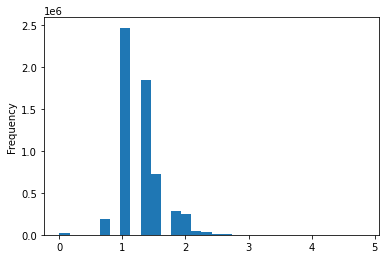

In [34]:
#train_set['target'].plot.hist(bins=20)
#valid_set['target'].plot.hist(bins=20)
max(train_set['target'])


train_set[train_set["target"] >= 20].count()["target"]
train_set[train_set["target"] < 20].count()["target"]

valid_set[valid_set["target"] >= 20].count()["target"]
valid_set[valid_set["target"] < 20].count()["target"]


log_train_y = np.log(train_set['target']+1)
log_train_y.plot.hist(bins=30)

## Conclusion
The max delivery date is 124, which is not too much a outlier..
There are also many predictions over 20, so the model is also considering extreme long cases.   

In general it doesnt make much sense to force predictions into some range, considering it's a tree model.